In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from CartPole import CartPole
from sklearn.model_selection import ParameterGrid
import sobol_seq
from scipy import interpolate

# Task 2.1

In [ ]:
#kernel function to evaluate the state varaibles
def kernel_func(x0,x1,sig):
    delta_x = x0-x1
    delta_x_2 = np.zeros([4,1])
    for i in range(4):
        delta_x_2[i]=(delta_x[i])**2
    delta_x_2[2]=np.sin(0.5*(delta_x[2]))**2
    expo = (-0.5)*float(np.dot(sig, delta_x_2))
    kernel = np.e**expo
    return kernel
#range of input for creating data
def r_range(i, minimum,maximum):
    d = i*(maximum-minimum)
    output = np.full(np.shape(i),minimum)+d
    return output
#generate datapoints using sobol_seq
def generate_x(n):
    x_data = sobol_seq.i4_sobol_generate(4,n)
    d_0=r_range(x_data[:,0],-50,50)
    d_1=r_range(x_data[:,1],-10,10)
    d_2=r_range(x_data[:,2],-(np.pi),np.pi)
    d_3=r_range(x_data[:,3],-15,15)
    output = np.column_stack((d_0,d_1,d_2,d_3))
    return output
n=1000
X = generate_x(n)
#find length scale parameters sigma for each state varaible
#ddof = delta degrees of freedom
data_sigma = np.array([np.std(X[:,i], ddof=1) for i in range(4)])
one_over_sig_data = [(1/i)**2 for i in data_sigma]
print(one_over_sig_data)

[0.0012013752781129235, 0.030003762739741355, 0.304526507983549, 0.013358927047652963]


In [ ]:
#Change in state 
change_s=CartPole()
Y_change_State = np.zeros([n,4])
for i in range(n):
    change_s.setState(X[i])
    change_s.performAction()
    Y_change_State[i]=change_s.getState()-X[i]

#Now generate subset M
M=1000
X_M = generate_x(M)
lamd = 1e-3
#length scale parameters for each state variable
one_over_sigma = [2.01375278e-10, 1.00037627e-05, 2.67489579e+00, 6.48794195e-02]
invert_sig = [1/np.sqrt(i) for i in one_over_sigma]
print(invert_sig)
#generate K matrix for datapoints
def K_matrix(a,b,sig_invert):
    A = np.shape(a)[0]
    B = np.shape(b)[0]
    K = np.zeros(shape=(A,B))
    for i in range(A):
        for j in range(B):
            K[i][j] =kernel_func(a[i],b[j],sig_invert)
    return K

test_data = np.zeros([n,4])
test_y_data = np.zeros([n,4])
for i in range(n):
    change_s.setState([np.random.uniform(-50,50),np.random.uniform(-10,10),np.random.uniform(-(np.pi),np.pi),np.random.uniform(-15,15)])
    test_data[i]=change_s.getState()
    change_s.performAction()
    test_y_data[i]=change_s.getState()-test_data[i]

Y_test_data = test_y_data

KNN=K_matrix(X,X,one_over_sigma)
KMN=K_matrix(X_M,X,one_over_sigma)
KNM=K_matrix(X,X_M,one_over_sigma)
KMM=K_matrix(X_M,X_M,one_over_sigma)
#alpha = (KMN@KNM + lamda*KMM)^-1(KMN@Y)
#alpha = (c)^-1*(d)
c = KMN @ KNM +lamd*KMM
d = np.zeros([4,M])
matrix_alphas = np.zeros([4,M])
for i in range(4):
    d[i] = KMN @ Y_change_State[:,i]
    matrix_alphas[i]=np.linalg.lstsq(c,d[i],rcond=-1)[0]
#Inaccurate sigma
KNN1=K_matrix(X,X,one_over_sig_data)
KMN1=K_matrix(X_M,X,one_over_sig_data)
KNM1=K_matrix(X,X_M,one_over_sig_data)
KMM1=K_matrix(X_M,X_M,one_over_sig_data)
c1 = KMN1 @ KNM1 +lamd*KMM1
d1 = np.zeros([4,M])
matrix_alphas1 = np.zeros([4,M])
for i in range(4):
    d1[i] = KMN1 @ Y_change_State[:,i]
    #rcond=-1 default
    matrix_alphas1[i]=np.linalg.lstsq(c1,d1[i],rcond=-1)[0]

#sum squared errors 
KNM_test = K_matrix(test_data,X_M,one_over_sigma)
Y_pred=KNM_test @ matrix_alphas.transpose()
y_diff = Y_pred-Y_test_data
cc = y_diff **2
square_err = np.zeros([4,1])
for i in range(4):
    square_err[i] = np.sum(cc[:,i])
print(square_err)
y_train_pred = KNM @ matrix_alphas.transpose()
y_train_diff = Y_change_State - y_train_pred
c0 =y_train_diff**2
#print(cc)
#print(c0)
#lamda = 1e-3, cc = 21.103, c0 = 8.2303,lamda = 1e-2, cc = 92.1, c0=71.11,lamda = 1e-1, cc = 498, c0 = 469
#lamda = 1e-4, cc = 11    , c0= 2.96,lamda = 1e-5, cc = 7.918, 1.572,lamda = 1e-6

[70468.80770283047, 316.16828929003316, 0.611429750368987, 3.925965892618322]
[[ 1.34558062]
 [ 1.354392  ]
 [ 0.02208105]
 [12.77628721]]


### Evaluating Square Errors varying M, Fixed N

In [ ]:
M_sqr_err_cl = [1344.4,1373,1307,1212.9,913,114,37.72,1.79,1.088,1.216,1.456,1.41,1.2734,1.241,1.778,1.3455]
M_sqr_err_cv = [606,316,140,42.8,28.4,7,3.28,1.568,1.389,1.405,1.33,1.286,1.349,1.48,1.536,1.354]
M_sqr_err_pa = [303.5,70,17.11,9.89,2.9,0.4,0.09,0.028,0.023,0.019,0.0215,0.0207,0.021,0.022,0.0219,0.02208]
M_sqr_err_pv = [5858,1103,782,326,279,110,43,14.86,13.31,12.48,12.39,11.795,12.387,14.54,14.84, 12.776]
x_M_step = [10,20,30,40,50,80,100,200,300,400,500,600,700,800,900,1000]

fig,axs = plt.subplots(1)
fig.suptitle('Squarred error against subset size (M) with N = 1000')
axs.plot(x_M_step,M_sqr_err_cl, label='Cart Location')
axs.plot(x_M_step, M_sqr_err_cv,color='r', label= 'Cart velocity')
axs.plot(x_M_step, M_sqr_err_pa, color = 'black', label = 'Pole Angle')
axs.plot(x_M_step, M_sqr_err_pv, color ='magenta', label='Pole Angular Velocity')
axs.set_yscale('log')
axs.set(xlabel='M')
axs.set(ylabel='Squarred Error Log Scale')
axs.legend()
plt.show()


fig,axs = plt.subplots(1)
fig.suptitle('Squarred error against subset size (M) with N = 1000')
axs.plot(x_M_step,M_sqr_err_cl, label='Cart Location')
axs.plot(x_M_step, M_sqr_err_cv,color='r', label= 'Cart velocity')
axs.plot(x_M_step, M_sqr_err_pa, color = 'black', label = 'Pole Angle')
axs.plot(x_M_step, M_sqr_err_pv, color ='magenta', label='Pole Angular Velocity')
axs.set(xlabel='M')
axs.set(ylabel='Squarred Error Log Scale')
axs.legend()
plt.show()


### Evaluating Square Errors varying N, Fixed M

In [ ]:
sqr_err = [[40.1, 1.9, 0.085, 27.3],[37.11,2.53,0.11,33.88 ],[48.33294, 3.61, 0.155, 54.96],[ 45.9, 3.9, 0.22, 62.6],[77.1, 5.8, 0.287, 91.8],[ 97.6, 6.9, 0.33, 110.3],[213, 13, 0.719, 228.5],[ 312.7, 20.2, 1.06, 322],[ 378.6, 26.84, 1.411, 468.144],[508.4,34.9,1.6523, 569.91],[1017.8, 69.9, 3.356,1130.8]]
print(sqr_err)
x_step = [100,200,400,500,800,1000,2000,3000,4000,5000,10000]
sqr_err_cl = [40.1,37.1,48.3,45.9,77.1,97.6,213,312,378.6,508.4,1018]
sqr_err_cv = [1.9,2.53,3.61,3.9,5.8,6.9,13,20.2,26.84,34.9,69.9]
sqr_err_pa =[0.085,0.11,0.155,0.22,0.287,0.33,0.719,1.06,1.411,1.65,3.356]
sqr_err_pv = [27.3,33.88,54.96,62.6,91.8,110.3,228.5,322,468,569.9,1130]

fig,axs = plt.subplots(1)
fig.suptitle('Squarred error against dataset (N) with M = 90')
axs.plot(x_step,sqr_err_cl, label='Cart Location')
axs.plot(x_step, sqr_err_cv,color='r', label= 'Cart velocity')
axs.plot(x_step, sqr_err_pa, color = 'black', label = 'Pole Angle')
axs.plot(x_step, sqr_err_pv, color ='magenta', label='Pole Angular Velocity')
axs.set_yscale('log')
axs.set(xlabel='N')
axs.set(ylabel='Squarred Error Log Scale')
axs.legend()
plt.show()


fig,axs = plt.subplots(1)
fig.suptitle('Squarred error against dataset (N) with M = 90')
axs.plot(x_step,sqr_err_cl, label='Cart Location')
axs.plot(x_step, sqr_err_cv,color='r', label= 'Cart velocity')
axs.plot(x_step, sqr_err_pa, color = 'black', label = 'Pole Angle')
axs.plot(x_step, sqr_err_pv, color ='magenta', label='Pole Angular Velocity')
axs.set(xlabel='')
axs.set(ylabel='Squarred Error Log Scale')
axs.legend()
plt.show()

### Time Evolution Plot

In [ ]:
labels_real = ['Real Change in Cart Location', 'Real Change in Cart Velocity', 'Real change in Pole Angle', 'Real Change in Pole Angular Velocity']
labels_pred = ['Predicted Change in Cart Location','Predicted Change in Cart Velocity','Predicted Change in Pole Angle', 'Predicted Change in Pole Angular Velocity']

def real_pred_evolution(n):
    real_states = np.zeros([n,4])
    pred_states = np.zeros([n,4])
    initial_state = change_s.getState()
    for i in range(n):
        real_states[i]=change_s.getState()
        change_s.performAction()
        change_s.remap_angle()
    change_s.setState(initial_state)
    for i in range(n):
        pred_states[i] = change_s.getState()
        K1M = np.array([kernel_func(pred_states[i],ss, one_over_sigma) for ss in X_M])
        delta_c = K1M @ matrix_alphas.transpose()
        new_pred = delta_c + pred_states[i]
        change_s.setState(new_pred)
    return(real_states, pred_states)
def real_pred_evolution_2(n):
    real_states = np.zeros([n,4])
    pred_states = np.zeros([n,4])
    initial_state = change_s.getState()
    for i in range(n):
        real_states[i]=change_s.getState()
        change_s.performAction()
        change_s.remap_angle()
    change_s.setState(initial_state)
    for i in range(n):
        pred_states[i] = change_s.getState()
        K1M = np.array([kernel_func(pred_states[i],ss, one_over_sig_data) for ss in X_M])
        delta_c = K1M @ matrix_alphas1.transpose()
        new_pred = delta_c + pred_states[i]
        change_s.setState(new_pred)
        change_s.remap_angle()
    return(real_states, pred_states)
n=500
t = np.arange(0,0.2*100,0.2)
for i in range(4):
        plt.scatter(t,real_states[:,i],color='black')
        plt.scatter(t,pred_states[:,i],color='royalblue')
        plt.scatter(t,pred_states_sig[:,i],color='red')
        plt.legend()
        plt.xlabel('time (s)')
        plt.xlim(0,10)
        plt.ylabel(labels_real[i])
        plt.title(labels_real[i] +' VS ' +labels_pred[i])
        plt.show()
for i in range(4):
        plt.plot(t,real_states[:,i],color='black',markersize=50, label = 'Actual')
        plt.plot(t,pred_states[:,i],color='royalblue',label = 'Predicted with optimised Sigma')
        plt.plot(t,pred_states_sig[:,i],color='red', label = 'Predicted with unoptimised Sigma')
        plt.legend(loc = 'upper right')
        plt.xlabel('time (s)')
        plt.xlim(0,10)
        plt.ylabel(labels_real[i])
        plt.title(labels_real[i] +' VS ' +labels_pred[i])
        plt.show()



### Contour Plots

In [ ]:
#Change in State against Cart Location and Pole Angle
x = CartPole()
m = 500
l = ['Cart location', 'Cart Velocity', 'Pole Angle', 'Pole Velocity']
r_state,step_state = np.zeros([m,4]),np.zeros([m,4])
for i in range(m):
    x.setState([np.random.uniform(-20,20),3,np.random.uniform(-np.pi,np.pi),3])
    r_state[i] = x.getState()
    #Perform update
    x.performAction()
    step_state[i] = x.getState()
    x.reset()
    
plt.tricontourf(r_state[:,0], r_state[:,2],Y_2_pred[:,1],20)
plt.title('The Change in ' + l[1] + ' against ' + l[0] + ' and ' + l[2])
plt.xlabel(l[0])
plt.ylabel(l[2])
plt.colorbar()
plt.show()
plt.tricontourf(r_state[:,0], r_state[:,2],Y_2_pred[:,3],20)
plt.title('The Change in ' + l[3] + ' against ' + l[0] + ' and ' + l[2])
plt.xlabel(l[0])
plt.ylabel(l[2])
plt.colorbar()
plt.show()

#plt.title('The Change in ' + l[1] + ' against ' + l[0] + ' and ' + l[2])
#plt.xlabel(l[0])
#plt.ylabel(l[2])
#plt.colorbar()
#plt.show()
#plt.tricontourf(state_b[0], state_b[2],state_d[3],10)
#plt.title('The Change in ' + l[3] + ' against ' + l[0] + ' and ' + l[2])
#plt.xlabel(l[0])
#plt.ylabel(l[2])
#plt.colorbar()
#plt.show()

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8]
[0.   3.   3.14 3.  ]


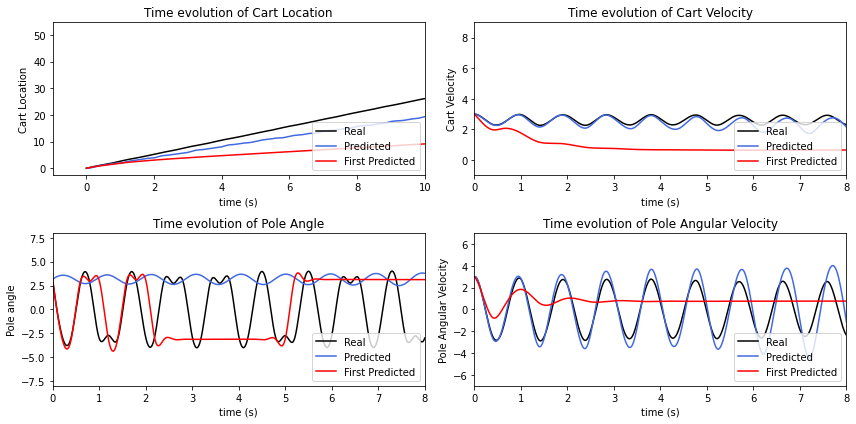

In [ ]:
labels =['Cart Location', 'Cart Velocity', 'Pole Angle', 'Pole Velocity']
t=np.arange(0,0.2*100,0.2)
x_new = np.linspace(0,20,10000)
sp = interpolate.make_interp_spline(t, real_states[:,0])
y_new_1 = sp(x_new)
sp2= interpolate.make_interp_spline(t, pred_states[:,0])
y_pred_1 = sp2(x_new)
sp3 = interpolate.make_interp_spline(t,pred_states_sig[:,0])
y_pred_sig = sp3(x_new)

x_new = np.linspace(0,20,10000)
sp = interpolate.make_interp_spline(t, real_states[:,1])
y_new_2 = sp(x_new)
sp2= interpolate.make_interp_spline(t, pred_states[:,1])
y_pred_2 = sp2(x_new)
sp3 = interpolate.make_interp_spline(t,pred_states_sig[:,1])
y_pred_sig_2 = sp3(x_new)
x_new = np.linspace(0,20,10000)
sp = interpolate.make_interp_spline(t, real_states[:,2])
y_new_3 = sp(x_new)
sp2= interpolate.make_interp_spline(t, pred_states[:,2])
y_pred_3 = sp2(x_new)
sp3 = interpolate.make_interp_spline(t,pred_states_sig[:,2])
y_pred_sig_3 = sp3(x_new)


x_new = np.linspace(0,20,10000)
sp = interpolate.make_interp_spline(t, real_states[:,3])
y_new_4 = sp(x_new)
sp2= interpolate.make_interp_spline(t, pred_states[:,3])
y_pred_4 = sp2(x_new)
sp3 = interpolate.make_interp_spline(t,pred_states_sig[:,3])
y_pred_sig_4 = sp3(x_new)


fig,axs = plt.subplots(2,2,figsize=(12, 6))
print(t)
print(real_states[0])
axs[0,0].plot(x_new,y_new_1,color='black', label = 'Real',markersize = 50)
axs[0,0].plot(x_new,y_pred_1,color='royalblue',label = 'Predicted')
axs[0,0].plot(x_new,y_pred_sig,color='red', label='First Predicted')
axs[0,0].set_title('Time evolution of Cart Location')
axs[0,0].set_xlim([0,8])
axs[0,0].set_xlim([-1,10])
axs[0,0].set(xlabel='time (s)',ylabel='Cart Location',)
axs[0,0].legend(loc='lower right')
axs[0,1].plot(x_new,y_new_2,color='black',label = 'Real')
axs[0,1].plot(x_new,y_pred_2,color='royalblue',label = 'Predicted')
axs[0,1].plot(x_new,y_pred_sig_2,color='red',label='First Predicted')
axs[0,1].set_title('Time evolution of Cart Velocity')
axs[0,1].set_xlim([0,8])
axs[0,1].set_ylim([-1,9])
axs[0,1].set(xlabel='time (s)',ylabel='Cart Velocity')
axs[0,1].legend(loc='lower right')
axs[1,0].plot(x_new,y_new_3,color='black',label = 'Real')
axs[1,0].plot(x_new,y_pred_3,color='royalblue',label = 'Predicted')
axs[1,0].plot(x_new,y_pred_sig_3,color='red',label='First Predicted')
axs[1,0].set_xlim([0,8])
axs[1,0].set_title('Time evolution of Pole Angle')
axs[1,0].set(xlabel='time (s)',ylabel='Pole angle')
axs[1,0].set_ylim([-8,8])
axs[1,0].legend(loc='lower right')
axs[1,1].plot(x_new,y_new_4,color = 'black',label = 'Real')
axs[1,1].plot(x_new,y_pred_4,color='royalblue',label = 'Predicted')
axs[1,1].plot(x_new,y_pred_sig_4,color='red',label='First Predicted')
axs[1,1].set_title('Time evolution of Pole Angular Velocity')
axs[1,1].set(xlabel='time (s)',ylabel='Pole Angular Velocity')
axs[1,1].set_xlim([0,8])
axs[1,1].set_ylim([-7,7])
axs[1,1].legend(loc='lower right')
fig.tight_layout()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=180073fb-9c10-447b-b721-e7b1d25fe36a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>